# AutoEncoder, Variational AutoEncoder and GAN

In [1]:
import numpy as np
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from typing import Sequence
import datetime
import copy
from os import listdir

## General instructions

Every two weeks you will be given an assignment related to the associated module. There are 3 weekly group sessions available to help you complete the assignments, you are invited to attend one of them each week. Attendance is not mandatory but recommended. However, assignments are graded and not submitting them or submitting them after the deadline will give you no points. The grading system is detailed [here](https://mitt.uib.no/courses/27468/pages/general-information)

**FORMAT**: Jupyter notebook    
**DEADLINE**: Sunday 16th May, 23:59

## Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train... In this assignment it will be totally okay if you don't get good results, we will provide examples of expected results and we don't expect you to spend the entire 2 weeks on the parameter tuning.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder
4. GAN

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models]


# 2. (Reminders) Encoder and Decoder

### Modules 

In the cell below are defined the following modules that we will need in this section

1. **MyEncoder**
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
1. **MyDecoder**
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image


In [2]:
class MyEncoder(nn.Module):
    """
    Encoder module: 
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4, stride=1)
        self.fc3 = nn.Linear(in_features=256, out_features=z_dim)
        
    def forward(self, x):
        N = x.shape[0]
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = out.view(N, -1)
        out = torch.relu(self.fc3(out))
        return out

class MyDecoder(nn.Module):
    """
    Decoder module: 
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
    """
    def __init__(self, z_dim):
        super().__init__() 
        c1 = 3
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 18*18)
        self.transconv3 = nn.ConvTranspose2d(in_channels=1, out_channels=1,  kernel_size=3, stride=1)
        
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = out.view(N, 1, 18, 18)
        out = torch.sigmoid(self.transconv3(out))
        return out

### Utils 

Some useful functions:

- **load_MNIST**: Return MNIST train and val dataset
- **plot_true_VS_reconstructed**: Plot side by side original images with their reconstructed counterparts using a trained VAE
- **plot_generated_images**: Plot images generated by a VAE
- **training_vae**: Training loop for a VAE

In [23]:
preprocessor = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.ToTensor(),
    transforms.Normalize(0.2475, 0.3892),
]) 


def load_MNIST(data_path='../data/', transform = preprocessor, labels_kept=[0,1,3,4,8]):
    """
    Return MNIST train and val dataset
    """
    MNIST_train = datasets.MNIST(
        data_path,       
        train=True,      
        download=True,   
        transform=transform
    )

    MNIST_val = datasets.MNIST(
        data_path, 
        train=False,      
        download=True,   
        transform=transform
    )

    print('Size of the original training dataset: ', len(MNIST_train))
    print('Size of the original validation dataset: ', len(MNIST_val))

    if len(labels_kept) <10:
        MNIST_train_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_train if label in labels_kept]
        MNIST_val_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_val if label in labels_kept]

        print('Size of the reduced training dataset: ', len(MNIST_train_reduced))
        print('Size of the reduced validation dataset: ', len(MNIST_val_reduced))
    else:
        MNIST_train_reduced = MNIST_train
        MNIST_val_reduced = MNIST_val

    return MNIST_train_reduced, MNIST_val_reduced

def plot_true_VS_reconstructed(ae, imgs):
    """
    Plot side by side original images with their reconstructed counterpart using a trained VAE
    """
    ae.eval()
    N_img = 25
    fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,6), sharex=True, sharey=True)
    for i, img in enumerate(imgs[:N_img]):
        with torch.no_grad():
            out = ae(img.unsqueeze(0))
            # True image
            axs.flat[2*i].imshow(img.permute(1, 2, 0).squeeze(2), cmap='Greys')
            # Reconstruction
            axs.flat[2*i + 1].imshow(out.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='Greys') 
            # Set ax title for the first row
            if i<5:
                axs.flat[2*i].set_title("True\nimage")
                axs.flat[2*i + 1].set_title("AE recon-\nstruction")
    return fig, axs

def plot_generated_images(vae):
    """
    Plot images generated by a VAE
    """
    vae.eval()
    N_img = 100
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(13,13), sharex=True, sharey=True, tight_layout=True)
    fig.suptitle("Image generation", fontsize=15)
    for i in range(N_img):
        with torch.no_grad():
            a_z = torch.randn(1,vae.z_dim)
            a_img = vae.decoder(a_z)
            axs.flat[i].imshow(a_img[0].permute(1, 2, 0).squeeze(2), cmap='Greys')
    return fig, axs

def training_vae(n_epochs, optimizer, model, loss_fn, train_loader, kld_weight=None, device=None):
    """
    Training loop for a VAE
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    if kld_weight is None:
        kld_weight = torch.ones(n_epochs)
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_train_mse = 0.
        loss_train_kld = 0.

        for imgs in train_loader:

            imgs = imgs.to(device=device) 

            outputs = model(imgs)
            mse_loss, kld_loss = loss_fn(outputs, imgs, model.mu, model.logvar)
            # Final loss is the sum of the 2 terms (with potentially a weight term)
            loss = mse_loss + kld_weight[epoch-1]*kld_loss
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            loss_train_mse += mse_loss.item()
            loss_train_kld += kld_loss.item()

        
        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {:3}  |  Training loss {:.3f}  |  MSE loss {:.3f}  |  KLD loss {:.12f}'.format(
                datetime.datetime.now(), 
                epoch,
                loss_train / len(train_loader),
                loss_train_mse / len(train_loader),
                loss_train_kld / len(train_loader),
            ))


In [4]:
# Load the data

# It's already hard enough to train VAE, a subset of MNIST will be more than enough.
labels_kept = [0,1,3,4,8]
data_train, data_val = load_MNIST(labels_kept=labels_kept)
imgs_train = [img for img, _ in data_train]
imgs_val = [img for img, _ in data_val]

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Size of the original training dataset:  60000
Size of the original validation dataset:  10000
Size of the reduced training dataset:  30489
Size of the reduced validation dataset:  5081


# 3. Variational AutoEncoder

*related videos from the curriculum*

- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=17) 
  - from 27:05 to 31:05: Introducting VAE 
  - *Let's forget about tractability :) *
  - from 40:55 to 44:00: VAE loss and VAE training
  - from 44:00 to 49:00: Generating data using VAE and summary 

**Introduction to VAE**

A Variational AutoEncoder (VAE) is a neural network that is similar to a AE in its structure as it is composed of 2 sub-networks: an Encoder and a Decoder. However now our main objective is not to efficiently represent some data lying on a non-linear manifold anymore. Instead we aim at generating some new data that would look like the training data but that is just a simple copy of a training input! We want **new** data.

To do so, we want our model to first get a good representation of what real data look like and then to be able to generate new plausible instances. The *get a good representation* part seems to be similar to what an Encoder can do and the *generate plausible instances* part to what a Decoder can do. However we can not really *generate new* data with a Decoder but just *reconstruct*. The *generate* part is actually what makes VAE different from AE and it is achieved in 2 steps: 

- a reparameterization step in the forward pass between the Encoder and Decoder
- a KL-divergence term added to the loss function 

These 2 steps aim at forcing the elements of latent space to look like normally distributed samples. Once the training is finished, this forcing will allow us to generate new data by simply giving a random normally distributed sample to the Decoder (and the Encoder can be thrown away, so this is the opposite of AE where we could throw away the Decoder and keep the Encoder).

**Reparameterization**

The reparameterization consists in defining the latent vector ``z`` not as the output of the encoder but as a random sample from $\mathcal{N}$(``mu``, ``std``$)$ where ``mu`` and ``std`` are the actual outputs of the Encoder (for computational reasons the Encoder actually returns ``mu`` and ``logvar (=log(std**2))``)

**KL-divergence**

The second difference between a VAE and an AE is in the loss function. In addition to the reconstruction term we want to force the Encoder to learn the parameters of a normal distribution. There exists a measure for that, the Kullback–Leibler divergence or simply KL-divergence ([Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html?highlight=kld#torch.nn.KLDivLoss)). The KL-divergence measures how one probability distribution $P$ is different from a second $Q$ by computing the following:

$$D_{KL}(P||Q) = \int_{-\infty}^{+\infty} p(x)log\Big(\frac{p(x)}{q(x)}\Big) \,dx \$$

Where $p$ and $q$ are the probability densities of the probability distributions $P$ and $Q$. This measure can be used for different purposes and have as many interpretations (see [Interpretations](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Interpretations) section from the Wikipedia page) but in the context of Variational AutoEncoder we will interpret $Q$ as our prior and $P$ as our *true* distribution and $D_{KL}(P||Q)$ can then be interpreted as the information lost when our prior $Q$ is used to approximate $P$. In our very specific case where $Q \sim \mathcal{N}(0, 1)$ and $P \sim \mathcal{N}$(``mu``, ``std``$)$, $D_{KL}(P||Q)$ can be formulated as follows (see [Multivariate normal distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) section from the Wikipedia page):

$$D_{KL}(P||Q) = \frac{1}{2} \sum_{i=1}^k \Big( \sigma_i^2 + \mu_i^2 -1 -log(\sigma_i^2) \Big) \qquad \text{with std} = \begin{bmatrix}\sigma_0 \cdots \sigma_{z_{dim}-1} \end{bmatrix} \quad \text{and mu} = \begin{bmatrix}\mu_0 \cdots \mu_{z_{dim}-1} \end{bmatrix}  $$


--------------------
## TODO - done!

### MyVAE class: A variational AutoEncoder

Complete the ``MyVAE`` class below (that is the variational counterpart of the ``MyAE`` class implemented in section 2). Normally you don't have to re-implement an encoder and a decoder, you can simply use the ``MyEncoder`` and the ``MyDecoder`` classes.  (defined at the beginning of this notebook as well). However a few details must be adapted:

1. Encoder must return 2 tensors of shape ``(N, z_dim)``: one for ``mu`` and one for ``logvar (=log(std**2))`` **or equivalently** use ``MyEncoder`` with ``z_dim = 2*z_dim`` and then define ``mu`` and ``logvar`` in the forward method as follows: 

  ```
  self.mu_logvar = self.encoder(x)               # Output of the encoder, shape=(N, 2*z_dim)
  self.mu = self.mu_logvar[:,:self.z_dim]        # mu                   , shape=(N, z_dim)   (1st half of the encoded vector)
  self.logvar = self.mu_logvar[:,self.z_dim:]    # logvar               , shape=(N, z_dim)   (2nd half of the encoded vector)
  ```

2. On top of returning the reconstructed image, the forward pass of your VAE must store ``mu`` and ``log`` (as suggested in the lines above) because we'll need them when computing the KL-divergence term of the loss function.

3. A ``reparameterization`` method must be added that draws a sample $z$ (of shape ``(N, z_dim)``) from $\mathcal{N}(0,1)$ and return $z*std + mu$ so that it corresponds to a sample from $\mathcal{N}$(``mu``, ``std``$)$ (Reminder: ``logvar = log(std**2))`` so ``std = exp(logvar)**(1/2)``). **Hint** you can use [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html?highlight=randn#torch.randn) or [torch.randn_like](https://pytorch.org/docs/stable/generated/torch.randn_like.html?highlight=randn#torch.randn_like) or [torch.nn.init.normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_). This method is to be called between the Encoder and the Decoder both during the training and can also be thrown away once the training is complete.

4. Decoder is exactly same as for an AutoEncoder

5. Write a ``generate_images`` method that takes as parameter an integer ``N_imgs`` defining the number of images to generate and returns ``imgs_generated`` (shape ``(N_imgs, C_in, H_in, W_in)``) the images generated by the VAE. **Hint** you can use [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html?highlight=randn#torch.randn)

### loss_VAE: A loss adapted to VAE

Complete the ``loss_VAE`` function below where 
- ``inputs`` is the original images (shape ``(N, C_in, H_in, W_in)``)
- ``outputs`` is the reconstructed images (shape ``(N, C_in, H_in, W_in)``), 
- ``mu`` and ``logvar (=log(std**2)`` are the outputs of the Encoder representing the parameters of our normal distribution $P$  (both of shape ``(N, z_dim)``)). 

It returns the 2 terms of the VAE loss function:
- ``mse_loss``, the reconstruction term. **Hint** you can use [F.mse_loss](https://pytorch.org/docs/stable/nn.functional.html?highlight=mse_loss#torch.nn.functional.mse_loss) with ``reduction="mean"``
- ``kld_loss``, the KL-divergence term. which is defined in the cell above. To adapt formula to batch computations, we need to re-write it as follows:

$$D_{KL}(P||Q) =\text{mean}\Big( \frac{1}{2} \sum_{i=1}^k \Big( \sigma_{:,i}^2 + \mu_{:,i}^2 -1 -log(\sigma_{:,i}^2) \Big) \Big) \qquad \text{with std} = \begin{bmatrix}\sigma_{:,0} \cdots \sigma_{:, z_{dim}-1} \end{bmatrix} \quad \text{and mu} = \begin{bmatrix}\mu_{:,0} \cdots \mu_{:, z_{dim}-1} \end{bmatrix}  $$




In [14]:
class MyVAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__() 
        # Latent space dimension
        self.z_dim = z_dim
        # Encoder similar to what we used for the AE but used to encode both mu and logvar 
        self.encoder = MyEncoder(2*z_dim) #TODO - done!
        # There is no difference between a VAE and AE decoder
        self.decoder = MyDecoder(z_dim) #TODO - done!

    def reparameterize(self):
        """
        Reparameterization: draw a sample z of shape (N, z_dim) (z~N(mu, logvar))

        mu and logvar should be accessible via self.mu and self.logvar
        """
        # Initialize a vector z with the right shape whose elements are drawn from a normal distribution N(0, 1)
        #TODO  - done!
        z = torch.randn_like(self.mu)

        # Shift z so that it is equivalent to a sample drawn from N(mu, std)
        #TODO - done!
        # torch.nn.init.normal_(z, mean=self.mu.float(), std=0.5*torch.exp(self.logvar))
        torch.nn.init.normal_(z)
        std = torch.exp(self.logvar)**(1/2)
        z = z * std + self.mu
        return z
        
    def forward(self, x):
        # Encode the data and output the estimated parameters mu and logvar
        #TODO - done!
        # mu can be defined as the first half of the encoder output
        self.mu_logvar = self.encoder(x)               # Output of the encoder, shape=(N, 2*z_dim)
        self.mu = self.mu_logvar[:,:self.z_dim]        # mu                   , shape=(N, z_dim)   (1st half of the encoded vector) #TODO
        # logvar can be defined as the second half of the encoder output
        self.logvar = self.mu_logvar[:,self.z_dim:]    # logvar               , shape=(N, z_dim)   (2nd half of the encoded vector) #TODO

        # Reparameterization: draw a sample z of shape (N, z_dim) (z~N(mu, logvar))
        # by calling the reparameterize method
        #TODO - done!
        z = self.reparameterize()

        # Generate (decode) an image from the sample z
        #TODO - done!
        out = self.decoder(z)
        return out

    def generate(self, N_imgs):
        """
        Generate new images by giving sampled latent vectors from N(0,1) to the decoder
        """
        #TODO - done!
        C_in, H_in, W_in = self.z_dim, self.z_dim, 1
        imgs_generated = self.decoder(torch.rand(size=(N_imgs, C_in, H_in, W_in)))
        return imgs_generated

def loss_VAE(inputs, outputs, mu, logvar):
    """
    Loss for a VAE: a reconstruction term (mse loss) and a distribution term (kl divergence)
    """
    # Regular reconstruction term using the mse loss, same as what we used for the AutoEncoder
    mse_loss =  F.mse_loss(outputs, inputs, reduction='mean') #TODO - done!
    # Distribution term: force the latent space to behave like a normal distribution
    # Special case of the KL divergence when the prior is Q~N(0,1) and P~N(mu, std)

    var = torch.exp(logvar)
    kld_loss = torch.mean(1/2 * torch.sum(var + mu**2 - 1 - logvar, dim=1)) #TODO - done!
    
    return mse_loss, kld_loss
                

### Training your Variational AutoEncoder

Run the cell below to train your VAE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).

In [17]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
z_dim = 15

vae = MyVAE(z_dim=z_dim)
vae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=512, shuffle=True)
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=512, shuffle=True)

lr = 0.3
momentum = 0.7

optimizer = optim.SGD(vae.parameters(), lr=lr, momentum=momentum)
loss_fn = loss_VAE

training_vae(
    n_epochs = 30,
    optimizer = optimizer,
    model = vae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
    device=device,
)

Training on device cpu.
2021-05-13 13:16:06.706377  |  Epoch  1  |  Training loss 1.036  |  MSE loss 1.035  |  KLD loss 0.001375544288
2021-05-13 13:16:11.303781  |  Epoch  2  |  Training loss 1.011  |  MSE loss 1.011  |  KLD loss 0.000000001583
2021-05-13 13:16:16.076809  |  Epoch  3  |  Training loss 1.008  |  MSE loss 1.008  |  KLD loss 0.000000001423
2021-05-13 13:16:20.696621  |  Epoch  4  |  Training loss 1.003  |  MSE loss 1.003  |  KLD loss 0.000000001220
2021-05-13 13:16:25.367280  |  Epoch  5  |  Training loss 0.994  |  MSE loss 0.994  |  KLD loss 0.000000001130
2021-05-13 13:16:30.009111  |  Epoch  6  |  Training loss 0.975  |  MSE loss 0.975  |  KLD loss 0.000000001023
2021-05-13 13:16:34.661478  |  Epoch  7  |  Training loss 0.954  |  MSE loss 0.954  |  KLD loss 0.000000000960
2021-05-13 13:16:39.282884  |  Epoch  8  |  Training loss 0.944  |  MSE loss 0.944  |  KLD loss 0.000000000901
2021-05-13 13:16:43.998916  |  Epoch  9  |  Training loss 0.939  |  MSE loss 0.939  |  K

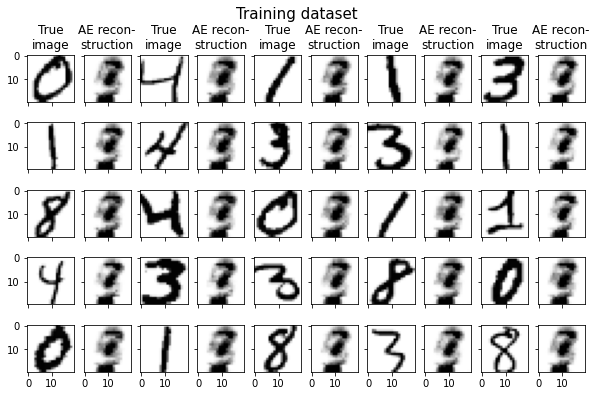

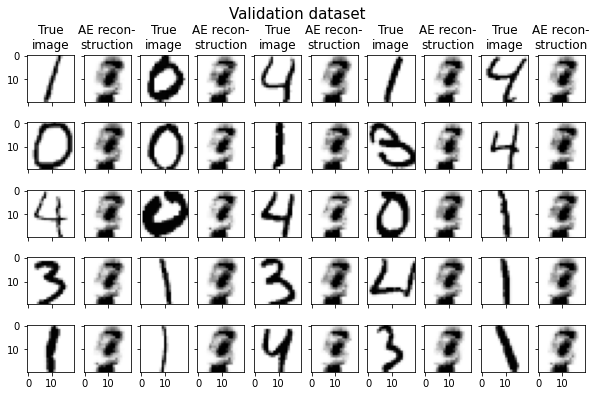

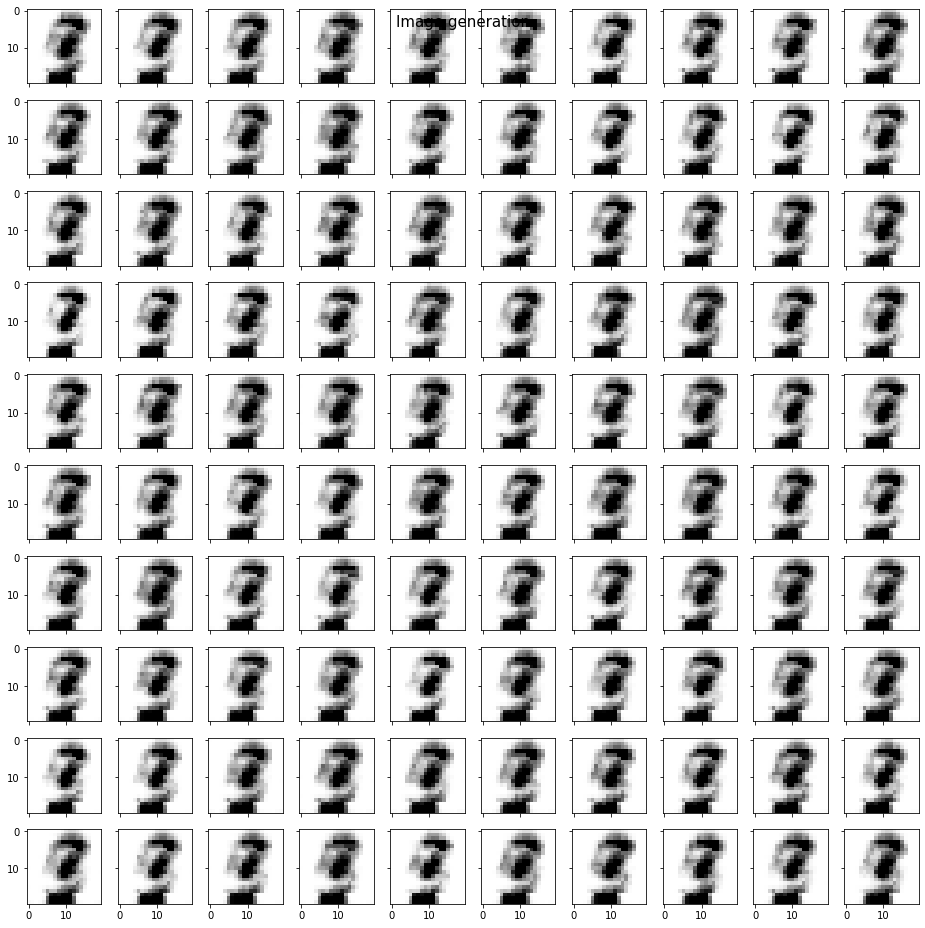

In [19]:
vae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(vae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(vae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()
fig, axs = plot_generated_images(vae)
plt.show()

### Example training loss

![Example of VAE training loss (see VAE_vanilla_training_loss image)](./VAE_vanilla_training_loss.png)

--------------------
## TODO - done!
Analyse the results in the image above.

1. Compare the evolution of the *MSE* loss with the *KL-divergence loss* and comment. 
    - It seems that MSE is lineary decreasing and KL-divergence loss is decreasing exponentialy (firstly, very quickly, then much slowly).
2. By looking at the loss what type of results do you expect? (Good reconstruction? Good distribution in the latent space?)
    - *KL-divergence loss* is much lover, so the distribution in the latent space should be good.
3. Recalling that for this assignment (and in its specific settings) we can say that our VAE learns well how to reconstruct if its training loss is lower than 0.6, would you say that the VAE is able to reconstruct well our data?
    - Training loss is higher than 0.6, so it is not able to reconstruct well the data.
    - When we look on reconstructed or generated images, they are not recognizable.

### Example reconstruction
![Example of VAE reconstruction results on the training dataset (see VAE_vanilla_train_reconstruction image)](./VAE_vanilla_train_reconstruction.png)

--------------------
## TODO - done!
Analyse the results in the image above.

1. Comment the behavior of the VAE when reconstructing different images.
    - It seems that the reconstruction is the same for all inputs. There are no significant differences.
2. Mode collapse is a very common problem when training VAE (and other unsupervised method), can you explain what this problem is?
    - Real data have usually some complex distribution (with not only one peak). _Mode collapse_ is the situation when model ignore some peaks and return either same result for all inputs (our case) or most of the generated samples shared some common parts.

### Example generation
![Example of VAE generation results (see VAE_vanilla_generation image)](./VAE_vanilla_generation.png)

--------------------
## TODO - done!
Analyse the results in the image above.

1. Do the generated images look similar to the outputs of the reconstructed images?
    - Yes, they look similar (i.e. some common parts are there).
1. Would you say that the VAE learnt well the parameters of a normal distribution?
    - Probably, VAE did not learn well the parameters, because the final result is poor.
    - It could learnt well the parameters; however, the generation is not working properly so at leas one part of VAE is not good (and it is hard to judge which one).

### Training your Variational AutoEncoder: with a weighted KLD loss

In order to fix the 'mode collapse' problem and to make sure our model learns to both reconstruct images and organize the latent space we will add a weight on the KL divergence term. We will first define this weight as extremely low so that the model learns first how to reconstruct and then we will increasingly amplify this weight so that the model re-organize the latent space properly. Once the weight is considered high enough we will stop increasing this weight let the model re-polish its reconstruction learning in this new organization. 

Run the cell below to train your VAE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).

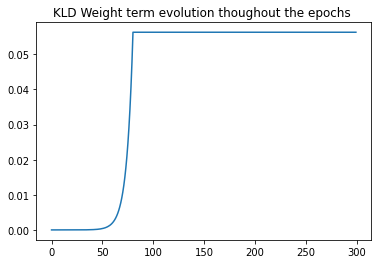

In [20]:
epochs = 300
kld_weight = torch.zeros(epochs)
kld_weight[0] = 0.0000001
for i in range(1,81):
     kld_weight[i] = kld_weight[i-1]*1.18
kld_weight[81:] = kld_weight[80]
plt.plot(np.arange(len(kld_weight)), kld_weight)
plt.title("KLD Weight term evolution thoughout the epochs ")
plt.show()

In [21]:
vae = MyVAE(z_dim=z_dim)
vae.to(device=device)
optimizer = optim.SGD(vae.parameters(), lr=lr, momentum=momentum)

training_vae(
    n_epochs = epochs,
    optimizer = optimizer,
    model = vae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
    kld_weight = kld_weight,
)

2021-05-13 13:19:24.417778  |  Epoch  1  |  Training loss 1.049  |  MSE loss 1.049  |  KLD loss 0.055665740371
2021-05-13 13:19:29.047789  |  Epoch  2  |  Training loss 1.012  |  MSE loss 1.012  |  KLD loss 0.102019542704
2021-05-13 13:19:33.649102  |  Epoch  3  |  Training loss 1.006  |  MSE loss 1.006  |  KLD loss 10.906631015241
2021-05-13 13:19:38.206566  |  Epoch  4  |  Training loss 0.978  |  MSE loss 0.978  |  KLD loss 366.149260330200
2021-05-13 13:19:42.857713  |  Epoch  5  |  Training loss 0.925  |  MSE loss 0.925  |  KLD loss 2624.997740427653
2021-05-13 13:19:47.531743  |  Epoch  6  |  Training loss 0.869  |  MSE loss 0.869  |  KLD loss 3707.731412760417
2021-05-13 13:19:52.234776  |  Epoch  7  |  Training loss 0.804  |  MSE loss 0.802  |  KLD loss 5936.247021484375
2021-05-13 13:19:56.893498  |  Epoch  8  |  Training loss 0.747  |  MSE loss 0.745  |  KLD loss 5560.246150716146
2021-05-13 13:20:01.759191  |  Epoch  9  |  Training loss 0.712  |  MSE loss 0.710  |  KLD loss 5

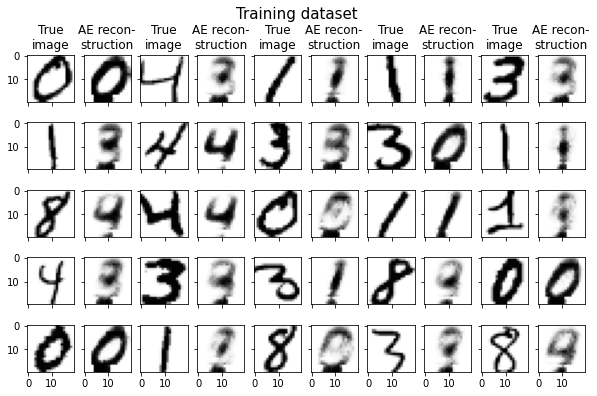

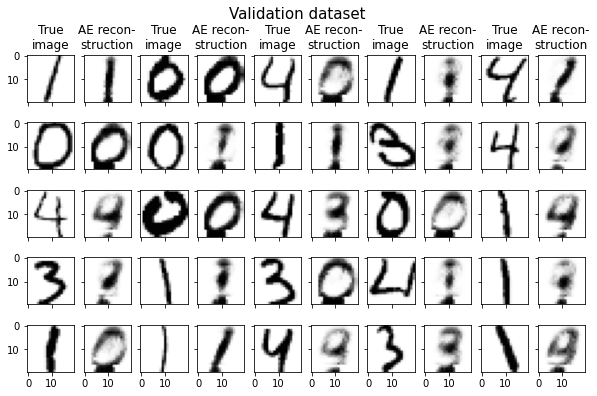

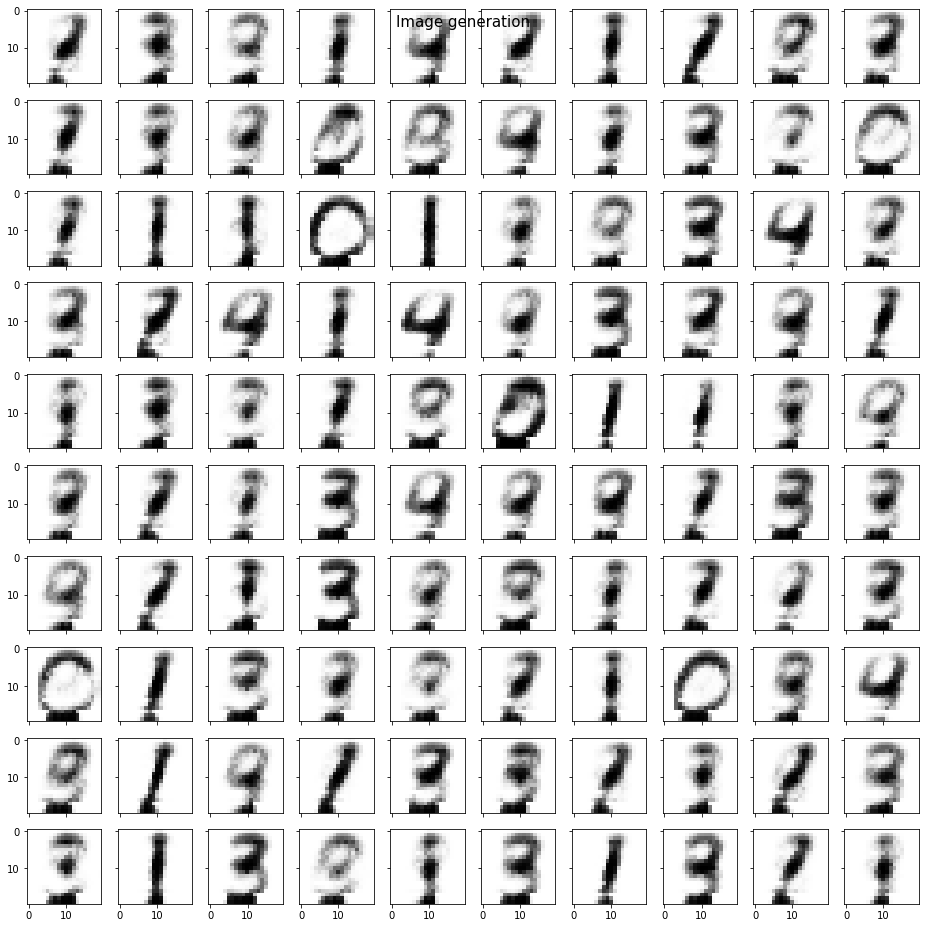

In [22]:
vae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(vae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(vae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()
fig, axs = plot_generated_images(vae)
plt.show()

### Example training loss

![Example of VAE training loss with the KLD weight term (see VAE_training_loss image)](./VAE_training_loss.png)

![Example of VAE training loss with the KLD weight term (see VAE_training_loss_end image)](./VAE_training_loss_end.png)

--------------------
## TODO - done!
Analyse the results in the 2 images above.

1. Compare the evolution of the MSE loss with the KL-divergence loss and comment. 
    - *MSE* is (again) slowly decreasing (seems linearly).
    - *KL-divergence loss* rapidly increased to very high numbers after first few steps and then it is slowly decreasing. But finally (after 300 epochs), the value is still higher than the value in the first few steps.
2. By looking at the loss what type of results do you expect? (Good reconstruction? Good distribution in the latent space?)
    - _MSE_ is lower than before, so the reconstruction should be better.
    - However, the distribution in the latent space is probably not so good (according to higher values of _KL-divergence loss_.
3. Recalling that for this assignment (and in its specific settings) we can say that our VAE learns well how to reconstruct if its training loss is lower than 0.6, would you say that the VAE is able to reconstruct well our data? 
    - According to the value we got, it seems, that there is no difference.
    - The value (0.91 after 300 epochs) is still quite far from the 0.6.

### Example reconstruction
![Example of VAE reconstruction results on the training dataset with the KLD weight term (see VAE_train_reconstruction image)](./VAE_train_reconstruction.png)

--------------------
## TODO - done!
Analyse the results in the image above.

1. Comment the behavior of the VAE when reconstructing different images.
    - Zeros (0), ones (1) and threes (3) are reconstructed quite well (at least recognizably).
    - Fours (4) and eights (8) are sometimes generated more like number three (3).

### Example generation
![Example of VAE generation results with the KLD weight term (see VAE_generation image)](./VAE_generation.png)

--------------------
## TODO - done!
Analyse the results in the image above.

1. Do the generated images look similar to the outputs of the reconstructed images?
    - Yes, they are similar (at least some of them); however, they are much noisy.
1. Would you say that the VAE learnt well the parameters of a normal distribution?
    - Yes, the generated images seem like numbers, so the VAE should be good.